In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from torch.optim import Adam
import torch.nn.functional as F
from torch.autograd import Variable
from fastai.vision import *
from torchsummary import summary
from torchvision import *

In [2]:
!nvidia-smi

Fri Apr 17 16:45:57 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 445.75       Driver Version: 445.75       CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce RTX 2060   WDDM  | 00000000:01:00.0  On |                  N/A |
| N/A   58C    P8     3W /  N/A |   1026MiB /  6144MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                                  |
|  GPU  

In [3]:
class CNN(nn.Module):
    def __init__(self, num_classes=3):
        super(CNN, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=12, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(12)
        self.relu1 = nn.ReLU()
#         self.relu1 = nn.PReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        
        self.poolA = nn.MaxPool2d(kernel_size=2)
        

        
        self.conv2 = nn.Conv2d(in_channels=12, out_channels=24, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(24)
        self.relu2 = nn.ReLU()
#         self.relu2 = nn.PReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2)
        
        
        
        self.conv3 = nn.Conv2d(in_channels=24, out_channels=48, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(48)
        self.relu3 = nn.ReLU()
#         self.relu3 = nn.PReLU()
        self.pool3 = nn.AvgPool2d(kernel_size=2)
        
        self.convM = nn.Conv2d(in_channels=84, out_channels=48, kernel_size=1, stride=1, padding=0)
        self.bnM = nn.BatchNorm2d(48)
        self.reluM = nn.ReLU()
#         self.reluM = nn.PReLU()
        self.poolM = nn.AvgPool2d(kernel_size=2)
        

        self.fc = nn.Linear(in_features=28 * 28 * 48, out_features=num_classes)

 

    def forward(self, input):
        output = self.conv1(input)
        output = self.bn1(output)
        output = self.relu1(output)
        output = self.pool1(output)
        
#         A = self.poolA(output)
#         print(A.shape)

        output = self.conv2(output)        
        output = self.bn2(output)
        output = self.relu2(output)
        output = self.pool2(output)
        
#         B = output
#         print(B.shape)


        
        output = self.conv3(output)                        
        output = self.bn3(output)
        output = self.relu3(output)
        output = self.pool3(output)    
        
#         output = torch.cat([output,A],dim = 1)
#         output = torch.cat([output,B],dim = 1)
        
#         output = self.convM(output)
#         output = self.bnM(output)
#         output = self.reluM(output)
#         output = self.poolM(output)
        
        output = output.view(-1, 28 * 28 * 48)
        output = self.fc(output)
        
        return output

In [3]:
size = 224
bs = 8
padding_model = 'reflection'
path = Path('D:/Appledisease/2020-3-29分割后的增强')
tfms = get_transforms(flip_vert=False, max_lighting=0., max_zoom=0., max_warp=0.)
data = (ImageList.from_folder(path).random_split_by_pct(0.2, seed=42)
        .label_from_folder()
        .transform(tfms,size=size)
        .databunch(bs=bs,num_workers=0).normalize(imagenet_stats))

C:\Users\Doublezore\Anaconda3\envs\gpu-pytorch\lib\site-packages\fastai\data_block.py:215: UserWarning: `random_split_by_pct` is deprecated, please use `split_by_rand_pct`.
  warn("`random_split_by_pct` is deprecated, please use `split_by_rand_pct`.")


In [4]:
data

ImageDataBunch;

Train: LabelList (668 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
Healthy Apple,Healthy Apple,Healthy Apple,Healthy Apple,Healthy Apple
Path: D:\Appledisease\2020-3-29分割后的增强;

Valid: LabelList (166 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
Tanju Apple,Tanju Apple,Healthy Apple,Tanju Apple,Healthy Apple
Path: D:\Appledisease\2020-3-29分割后的增强;

Test: None

In [5]:
# learn = Learner(data, models.resnet50, loss_func = nn.CrossEntropyLoss(), metrics=[accuracy])
learn = create_cnn(data, models.resnet50,pretrained=False,metrics=[accuracy])

C:\Users\Doublezore\Anaconda3\envs\gpu-pytorch\lib\site-packages\fastai\vision\learner.py:106: UserWarning: `create_cnn` is deprecated and is now named `cnn_learner`.
  warn("`create_cnn` is deprecated and is now named `cnn_learner`.")


In [6]:
learn.fit_one_cycle(300)

epoch,train_loss,valid_loss,accuracy,time
0,1.432725,0.996924,0.638554,00:30
1,1.250832,0.721533,0.692771,00:25
2,1.088223,0.680954,0.704819,00:26
3,1.024856,0.695266,0.740964,00:27
4,0.995751,0.662095,0.722892,00:28
5,0.899925,0.537052,0.753012,00:29
6,0.927172,0.666264,0.698795,00:29
7,0.933550,0.535028,0.789157,00:30
8,0.909737,0.696992,0.728916,00:30
9,0.848616,0.542484,0.789157,00:30


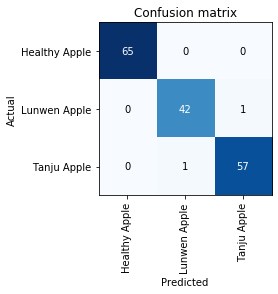

In [7]:
interp = ClassificationInterpretation.from_learner(learn)
# losses,idxs = interp.top_losses()
interp.plot_confusion_matrix()